In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)

In [2]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

warnings.filterwarnings(action='ignore')

if get_ipython():
    print("jupyter envirionment")
    PROJECT_DIR = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
    from tqdm import tqdm_notebook as tqdm  # 이거 안해주면 한 줄씩 출력됨 ;;
else:
    print("command shell envirionment")
    PROJECT_DIR = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
    from tqdm import tqdm

# sys.pathdp PROJECT_DIR 추가
sys.path.insert(0, PROJECT_DIR)

jupyter envirionment


In [3]:
with open('train.jsonl', 'r') as json_file:
    json_list = list(json_file)

trains = []
for json_str in json_list:
    line = json.loads(json_str)
    trains.append(line)

train_df = pd.DataFrame(trains)
train_df.head()

,media,id,article_original,abstractive,extractive
0,당진시대,327827480,[당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것...,지난 6일 당진시의회 행정사무감사에서 '합창단이 소리를 작게 낼 것이니 알고 있으라...,"[0, 1, 2]"
1,국제신문,339840364,[미국 메이저리그(MLB)에서 활동하는 한국 선수들의 시즌 초반 희비가 엇갈리고 있...,LA 에인절스의 최지만이 맹활약을 하여 시즌 타율 0.250에서 0.313으로 올리...,"[0, 1, 3]"
2,기호일보,371071597,"[인천 부영공원 운영 생활야구협회 80여 동호회 팀에 260만 원씩 받아, 국유지로...",16일 부평구와 협회 등에 따르면 부영공원 안에 있는 야구장을 구생활체육야구협회가 ...,"[6, 7, 10]"
3,대구일보,354806783,[대구·경북첨단의료산업진흥재단 의약생산센터는 항암주사제 무균충전 시설을 갖추고 있다...,대구·경북첨단의료산업진흥재단 의약생산센터는 약사법 시행규칙에서 정한 바에 따라 전용...,"[1, 6, 4]"
4,대구신문,347022773,[국내 유통되는 탄산음료 중 식품의약품안전처에 품질인증을 받은 제품이 하나도 없는 ...,식품의약품안전처는 29일 어린이가 즐겨마시는 음료를 대상으로 영양성분을 조사한 결과...,"[2, 3, 10]"


In [4]:
data = train_df[['article_original','abstractive']]
data.head()

,article_original,abstractive
0,[당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것...,지난 6일 당진시의회 행정사무감사에서 '합창단이 소리를 작게 낼 것이니 알고 있으라...
1,[미국 메이저리그(MLB)에서 활동하는 한국 선수들의 시즌 초반 희비가 엇갈리고 있...,LA 에인절스의 최지만이 맹활약을 하여 시즌 타율 0.250에서 0.313으로 올리...
2,"[인천 부영공원 운영 생활야구협회 80여 동호회 팀에 260만 원씩 받아, 국유지로...",16일 부평구와 협회 등에 따르면 부영공원 안에 있는 야구장을 구생활체육야구협회가 ...
3,[대구·경북첨단의료산업진흥재단 의약생산센터는 항암주사제 무균충전 시설을 갖추고 있다...,대구·경북첨단의료산업진흥재단 의약생산센터는 약사법 시행규칙에서 정한 바에 따라 전용...
4,[국내 유통되는 탄산음료 중 식품의약품안전처에 품질인증을 받은 제품이 하나도 없는 ...,식품의약품안전처는 29일 어린이가 즐겨마시는 음료를 대상으로 영양성분을 조사한 결과...


In [5]:
# 랜덤으로 10개의 샘플 출력
data.sample(10)

,article_original,abstractive
20221,"[‘버닝썬 쓰나미’지역에 상륙 업주들 ‘벌벌’, 광주국세청, 지역 유흥업소 1곳 조...",버닝썬 사건의 여파로 국세청이 유흥업소 대상 불법행위 전수 조사 중에 광주 지역의 ...
5211,[김포대학교 글로벌케이컬쳐센터(센터장 박진영ㆍ이하 센터)는 2018 경기꿈의대학 운...,2018 경기꿈의대학 운영에 기여한 공헌을 인정받은 김포대학교 글로벌케이컬쳐센터가 ...
16489,"[명품 치유?, 힐링 산림복지단지 조성, 백운산 명품 치유·힐링 산림복지단지 조성을...",‘광양 백운산 산림복지지구’가 도내에서는 최초로 지정되면서 백운산 명품 치유·힐링 ...
32813,[문재인 대통령은 ‘2·8 독립선언’ 100주년인 8일 이날의 의미를 되새기는 글을...,3.1독립운동에 직접적인 영향을 준 2.8독립선언의 의미를 담은 안내서가 일본 도쿄...
17953,[5월 법정 공휴일은 어린이날(5.5)과 부처님오신날(5.12) 이틀이지만 올해 모...,어린이날과 부처님오신날이 모두 일요일과 겹쳐 있지만 어린이날은 대체공휴일로 지정되어...
19922,[곽점홍 세종시 환경녹지국장은 14일 세종시청 브리핑실에서 열린 정례브리핑을 통해 ...,곽점홍 세종시 환경녹지국장은 사업비 1160억 원이 투입되는 조치원 청춘공원을 20...
1218,"[이인호(오른쪽부터) 한국무역보험공사 사장과 조홍래 이노비즈협회 회장, 진옥동 신한...",한국무역보험공사가 15일 이노비즈협회 및 신한은행과 수출 안전망 단체 보험 등을 내...
13052,[지난 10월1일 대구 성곡초등학교에서 대구FC ‘건강한 학교 즐거운 스포츠 사업’...,올해 DGB대구은행파크로 홈 경기장을 옮긴 대구는 평균 관중이 전년 대비 305.1...
31374,"[31개의 마을이 자리한 송악읍은 과거와 달리 이제는 도·농복합지역이다., 현대제철...","31개 마을이 모여있는 송악읍은 과거와 달리 이제는 도·농복합지역이 되었고, 송악읍..."
3230,"[4월 ‘엘리오스구월’ 설립 후 외관·리모델링 없이 그대로, 롯데 ""매입社 할 일""...",타디그레이드홀딩스가 백화점 운영을 위해 엘리오스구월을 설립해 옛 롯데 백화점 인천점...


In [6]:
# !pip install kss

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf
import kss

In [15]:
def spl_sentence(lines):
    sentence_tokenized_text = []
    for i, line in enumerate(lines):
        line = str(line).strip()
        for sent in kss.split_sentences(line):
            sentence_tokenized_text.append(sent.strip())
            
    return sentence_tokenized_text

In [16]:
text_s = spl_sentence(data['article_original'])
summary_s = spl_sentence(data['abstractive'])

In [17]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [18]:
def clean_punc(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text.strip()

In [19]:
cleaned_text = []
for sent in sentence_tokenized_text:
    cleaned_text.append(clean_punc(sent, punct, punct_mapping))

In [20]:
cleaned_text

['[   \'  당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것으로 추정되는 문자와 관련해 당진시의회가 행정사무조사특별위원회를 구성해 조사하겠다고 밝혔다 .   \'   ,    \'  당진시의회 행정사무감사 3일차였던 지난 6일 문화관광과를 대상으로 하는 행감에서 최창용 의원은   "   ( 당진시립합창단 정기연주회를 앞두고 )  문자메세지를 제보받았다  "  며   "   ( 음향팀에 보낸 것으로 추정되는 )  해당 문자에는   \'  합창단이 소리를 작게 낼 것이니 알고 있으라  \'  는 내용이었다  "  고 말했다 .   \'   ,    \'  이어   "  공연에서 소리를 작게 낸다는 것은 합창단으로서 그 임무를 하지 않겠다는 것  "  이며   "  공연 자체를 무력화해 당진시를 망신 주려는 행위  "  라며 해당 문자를 보낸 단원 등 연루된 사람들을 찾아 사실관계를 확인하고 징계 등 책임을 물어야 한다고 지적했다 .   \'   ,    \'  문제의 문자메세지를 전달받은 문화관광과는 감사법무담당관에게 조사를 의뢰했다 .   \'   ,    \'  권경선 문화관광과장은   "  누가 ,  어떻게 해서 해당 문자가 나온 것인지 정확히 조사해봐야 알 수 있다  "  며   "  전달받은 문자 내용도 최 의원이 언급한 부분만 있어 ,  중간 내용만을 가지고는 전체를 유추할 수 없다  "  고 전했다 .   \'   ,    \'  하지만 감사법무담당관실에서 아직 조사가 이뤄지지 않고 있어 당진시가 사태의 심각성을 인지하지 못하고 있다는 지적이다 .   \'   ,    \'  그동안 행정사무감사가 진행되고 있어 사태를 지켜봤다던 감사법무담당관실에서는   "  관계된 사람들을 조사해 사태를 파악해야 하는데 ,  아직 조사에 대한 뚜렷한 계획이 없다  "  고 답했다 .   \'   ,    \'  한편 행감이 끝난 지난 12일 당진시의회에서는 당진시립합창단 문제를 비롯해 구체적인 조사가 필요한 부분에 대해 행정사무

In [21]:
cleaned_summary = []
for sent in sentence_tokenized_text:
    cleaned_summary.append(clean_punc(sent, punct, punct_mapping))

In [22]:
cleaned_summary

['[   \'  당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것으로 추정되는 문자와 관련해 당진시의회가 행정사무조사특별위원회를 구성해 조사하겠다고 밝혔다 .   \'   ,    \'  당진시의회 행정사무감사 3일차였던 지난 6일 문화관광과를 대상으로 하는 행감에서 최창용 의원은   "   ( 당진시립합창단 정기연주회를 앞두고 )  문자메세지를 제보받았다  "  며   "   ( 음향팀에 보낸 것으로 추정되는 )  해당 문자에는   \'  합창단이 소리를 작게 낼 것이니 알고 있으라  \'  는 내용이었다  "  고 말했다 .   \'   ,    \'  이어   "  공연에서 소리를 작게 낸다는 것은 합창단으로서 그 임무를 하지 않겠다는 것  "  이며   "  공연 자체를 무력화해 당진시를 망신 주려는 행위  "  라며 해당 문자를 보낸 단원 등 연루된 사람들을 찾아 사실관계를 확인하고 징계 등 책임을 물어야 한다고 지적했다 .   \'   ,    \'  문제의 문자메세지를 전달받은 문화관광과는 감사법무담당관에게 조사를 의뢰했다 .   \'   ,    \'  권경선 문화관광과장은   "  누가 ,  어떻게 해서 해당 문자가 나온 것인지 정확히 조사해봐야 알 수 있다  "  며   "  전달받은 문자 내용도 최 의원이 언급한 부분만 있어 ,  중간 내용만을 가지고는 전체를 유추할 수 없다  "  고 전했다 .   \'   ,    \'  하지만 감사법무담당관실에서 아직 조사가 이뤄지지 않고 있어 당진시가 사태의 심각성을 인지하지 못하고 있다는 지적이다 .   \'   ,    \'  그동안 행정사무감사가 진행되고 있어 사태를 지켜봤다던 감사법무담당관실에서는   "  관계된 사람들을 조사해 사태를 파악해야 하는데 ,  아직 조사에 대한 뚜렷한 계획이 없다  "  고 답했다 .   \'   ,    \'  한편 행감이 끝난 지난 12일 당진시의회에서는 당진시립합창단 문제를 비롯해 구체적인 조사가 필요한 부분에 대해 행정사무

In [23]:
def clean_text(texts):
    corpus = []
    for i in range(0,len(texts)):
        sents = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts[i]))
        sents = re.sub(r'\s+', ' ', str(sents))
        sents = re.sub(r'\s+', ' ', str(sents))
        sents = re.sub(r"^\s+", '', str(sents))
        sents = re.sub(r'\s+$', '', str(sents))
        corpus.append(sents)
        
    return corpus


In [24]:
text = clean_text(cleaned_text)
summary = clean_text(cleaned_summary)

In [26]:
summary

['[ 당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것으로 추정되는 문자와 관련해 당진시의회가 행정사무조사특별위원회를 구성해 조사하겠다고 밝혔다 당진시의회 행정사무감사 3일차였던 지난 6일 문화관광과를 대상으로 하는 행감에서 최창용 의원은 당진시립합창단 정기연주회를 앞두고 문자메세지를 제보받았다 며 음향팀에 보낸 것으로 추정되는 해당 문자에는 합창단이 소리를 작게 낼 것이니 알고 있으라 는 내용이었다 고 말했다 이어 공연에서 소리를 작게 낸다는 것은 합창단으로서 그 임무를 하지 않겠다는 것 이며 공연 자체를 무력화해 당진시를 망신 주려는 행위 라며 해당 문자를 보낸 단원 등 연루된 사람들을 찾아 사실관계를 확인하고 징계 등 책임을 물어야 한다고 지적했다 문제의 문자메세지를 전달받은 문화관광과는 감사법무담당관에게 조사를 의뢰했다 권경선 문화관광과장은 누가 어떻게 해서 해당 문자가 나온 것인지 정확히 조사해봐야 알 수 있다 며 전달받은 문자 내용도 최 의원이 언급한 부분만 있어 중간 내용만을 가지고는 전체를 유추할 수 없다 고 전했다 하지만 감사법무담당관실에서 아직 조사가 이뤄지지 않고 있어 당진시가 사태의 심각성을 인지하지 못하고 있다는 지적이다 그동안 행정사무감사가 진행되고 있어 사태를 지켜봤다던 감사법무담당관실에서는 관계된 사람들을 조사해 사태를 파악해야 하는데 아직 조사에 대한 뚜렷한 계획이 없다 고 답했다 한편 행감이 끝난 지난 12일 당진시의회에서는 당진시립합창단 문제를 비롯해 구체적인 조사가 필요한 부분에 대해 행정사무조사특별위원회를 구성해 운영하겠다고 밝혔다 김기재 의장은 본회의 의결과 제적의원 1 3의 발의가 있으면 행정사무조사특별위원회를 구성할 수 있다 며 다음 달 초 위원들과 상의해 위원회를 구성한다면 당진시립합창단 관련 사안을 비롯해 사회복지기관 위수탁 등에 대해 다룰 계획 이라고 말했다 ]',
 '[ 미국 메이저리그 MLB 에서 활동하는 한국 선수들의 시즌 초반 희비가 엇갈리고 있다 LA 에인절스의 최지만은

In [27]:
# Sentence 분포
import collections

temp = []
for l in train_df['extractive']:
    temp.append(len(l))
    
collections.Counter(temp)

Counter({3: 42566, 2: 234, 1: 3})

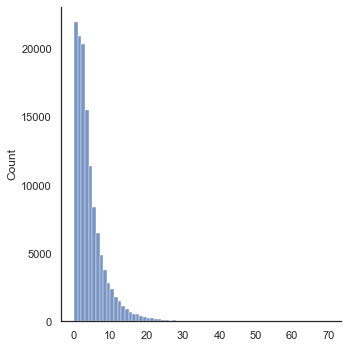

In [28]:
extractives = []
for extractive_idxes in train_df['extractive'].values:
    extractives += extractive_idxes

sns.displot(extractives, binwidth=1)  # , x="flipper_length_mm"

###### !pip install soynlp

In [33]:
# from soynlp.noun import LRNounExtractor
# noun_extractor = LRNounExtractor()
# nouns = noun_extractor.train_extract(str(data['article_original']))

In [37]:
text_w = []
for sentence in text:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    text_w.append(sentence)
    
summary_w = []
for sentence in summary:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    summary_w.append(sentence)

In [38]:
text_w

['[ 당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것으로 추정되는 문자와 관련해 당진시의회가 행정사무조사특별위원회를 구성해 조사하겠다고 밝혔다 당진시의회 행정사무감사 3일차였던 지난 6일 문화관광과를 대상으로 하는 행감에서 최창용 의원은 당진시립합창단 정기연주회를 앞두고 문자메세지를 제보받았다 며 음향팀에 보낸 것으로 추정되는 해당 문자에는 합창단이 소리를 작게 낼 것이니 알고 있으라 는 내용이었다 고 말했다 이어 공연에서 소리를 작게 낸다는 것은 합창단으로서 그 임무를 하지 않겠다는 것 이며 공연 자체를 무력화해 당진시를 망신 주려는 행위 라며 해당 문자를 보낸 단원 등 연루된 사람들을 찾아 사실관계를 확인하고 징계 등 책임을 물어야 한다고 지적했다 문제의 문자메세지를 전달받은 문화관광과는 감사법무담당관에게 조사를 의뢰했다 권경선 문화관광과장은 누가 어떻게 해서 해당 문자가 나온 것인지 정확히 조사해봐야 알 수 있다 며 전달받은 문자 내용도 최 의원이 언급한 부분만 있어 중간 내용만을 가지고는 전체를 유추할 수 없다 고 전했다 하지만 감사법무담당관실에서 아직 조사가 이뤄지지 않고 있어 당진시가 사태의 심각성을 인지하지 못하고 있다는 지적이다 그동안 행정사무감사가 진행되고 있어 사태를 지켜봤다던 감사법무담당관실에서는 관계된 사람들을 조사해 사태를 파악해야 하는데 아직 조사에 대한 뚜렷한 계획이 없다 고 답했다 한편 행감이 끝난 지난 12일 당진시의회에서는 당진시립합창단 문제를 비롯해 구체적인 조사가 필요한 부분에 대해 행정사무조사특별위원회를 구성해 운영하겠다고 밝혔다 김기재 의장은 본회의 의결과 제적의원 1 3의 발의가 있으면 행정사무조사특별위원회를 구성할 수 있다 며 다음 달 초 위원들과 상의해 위원회를 구성한다면 당진시립합창단 관련 사안을 비롯해 사회복지기관 위수탁 등에 대해 다룰 계획 이라고 말했다 ]',
 '[ 미국 메이저리그 MLB 에서 활동하는 한국 선수들의 시즌 초반 희비가 엇갈리고 있다 LA 에인절스의 최지만은

In [88]:
# text_words = []
# for sents in text:
#     words_splited = re.split(" ", str(sents))
#     text_words.append(words_splited)


# print(text_words[:10])

In [89]:
# summary_words = []
# for sents in summary:
#     words_splited = re.split(" ", str(sents))
#     summary_words.append(words_splited)


# print(summary_words[:10])

In [121]:
print(text_w)

['[ 당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것으로 추정되는 문자와 관련해 당진시의회가 행정사무조사특별위원회를 구성해 조사하겠다고 밝혔다 당진시의회 행정사무감사 3일차였던 지난 6일 문화관광과를 대상으로 하는 행감에서 최창용 의원은 당진시립합창단 정기연주회를 앞두고 문자메세지를 제보받았다 며 음향팀에 보낸 것으로 추정되는 해당 문자에는 합창단이 소리를 작게 낼 것이니 알고 있으라 는 내용이었다 고 말했다 이어 공연에서 소리를 작게 낸다는 것은 합창단으로서 그 임무를 하지 않겠다는 것 이며 공연 자체를 무력화해 당진시를 망신 주려는 행위 라며 해당 문자를 보낸 단원 등 연루된 사람들을 찾아 사실관계를 확인하고 징계 등 책임을 물어야 한다고 지적했다 문제의 문자메세지를 전달받은 문화관광과는 감사법무담당관에게 조사를 의뢰했다 권경선 문화관광과장은 누가 어떻게 해서 해당 문자가 나온 것인지 정확히 조사해봐야 알 수 있다 며 전달받은 문자 내용도 최 의원이 언급한 부분만 있어 중간 내용만을 가지고는 전체를 유추할 수 없다 고 전했다 하지만 감사법무담당관실에서 아직 조사가 이뤄지지 않고 있어 당진시가 사태의 심각성을 인지하지 못하고 있다는 지적이다 그동안 행정사무감사가 진행되고 있어 사태를 지켜봤다던 감사법무담당관실에서는 관계된 사람들을 조사해 사태를 파악해야 하는데 아직 조사에 대한 뚜렷한 계획이 없다 고 답했다 한편 행감이 끝난 지난 12일 당진시의회에서는 당진시립합창단 문제를 비롯해 구체적인 조사가 필요한 부분에 대해 행정사무조사특별위원회를 구성해 운영하겠다고 밝혔다 김기재 의장은 본회의 의결과 제적의원 1 3의 발의가 있으면 행정사무조사특별위원회를 구성할 수 있다 며 다음 달 초 위원들과 상의해 위원회를 구성한다면 당진시립합창단 관련 사안을 비롯해 사회복지기관 위수탁 등에 대해 다룰 계획 이라고 말했다 ]', '[ 미국 메이저리그 MLB 에서 활동하는 한국 선수들의 시즌 초반 희비가 엇갈리고 있다 LA 에인절스의 최지만은 

In [125]:
def remove_nspl(sentence):
    words = []
    for s in sentence:
        s = s[1:-1]
        line = s.split(' ')
        words.append(line)
    
    return(words)

In [ ]:
te = remove_nspl(text_w)
su = remove_nspl(summary_w)

In [131]:
print(su)

[['당진시', '문화관광과를', '대상으로', '하는', '행정사무감사에서', '당진시립합창단', '관계자가', '보낸', '것으로', '추정되는', '문자와', '관련해', '당진시의회가', '행정사무조사특별위원회를', '구성해', '조사하겠다고', '밝혔다', '당진시의회', '행정사무감사', '3일차였던', '지난', '6일', '문화관광과를', '대상으로', '하는', '행감에서', '최창용', '의원은', '당진시립합창단', '정기연주회를', '앞두고', '문자메세지를', '제보받았다', '며', '음향팀에', '보낸', '것으로', '추정되는', '해당', '문자에는', '합창단이', '소리를', '작게', '낼', '것이니', '알고', '있으라', '는', '내용이었다', '고', '말했다', '이어', '공연에서', '소리를', '작게', '낸다는', '것은', '합창단으로서', '그', '임무를', '하지', '않겠다는', '것', '이며', '공연', '자체를', '무력화해', '당진시를', '망신', '주려는', '행위', '라며', '해당', '문자를', '보낸', '단원', '등', '연루된', '사람들을', '찾아', '사실관계를', '확인하고', '징계', '등', '책임을', '물어야', '한다고', '지적했다', '문제의', '문자메세지를', '전달받은', '문화관광과는', '감사법무담당관에게', '조사를', '의뢰했다', '권경선', '문화관광과장은', '누가', '어떻게', '해서', '해당', '문자가', '나온', '것인지', '정확히', '조사해봐야', '알', '수', '있다', '며', '전달받은', '문자', '내용도', '최', '의원이', '언급한', '부분만', '있어', '중간', '내용만을', '가지고는', '전체를', '유추할', '수', '없다', '고', '전했다', '하지만', '감사법무담당관실에서', '아직', '조사가', '이뤄지지', '않고', '있어', '당진시가', '사태의', '심각성을

In [ ]:
# sample_list = list(filter(lambda v: v, sample_list))

In [97]:
# !pip3 install kobert-transformers

In [99]:
# import torch
# from kobert_transformers import get_kobert_model, get_distilkobert_model
# model = get_kobert_model()
# model.eval()
# input_ids = torch.LongTensor([[31,51,99],[15,5,0]])
# attention_mask = torch.LongTensor([[1,1,1],[1,1,0]])
# token_type_ids = torch.LongTensor([[0,0,1],[0,1,0]])
# sequence_output, pooled_output = model(input_ids,attention_mask,token_type_ids)
# sequence_output[0]

In [164]:
sumrylist = []
for i in su[0]:
    sumrylist.append(i)

print(sumrylist)

['당진시', '문화관광과를', '대상으로', '하는', '행정사무감사에서', '당진시립합창단', '관계자가', '보낸', '것으로', '추정되는', '문자와', '관련해', '당진시의회가', '행정사무조사특별위원회를', '구성해', '조사하겠다고', '밝혔다', '당진시의회', '행정사무감사', '3일차였던', '지난', '6일', '문화관광과를', '대상으로', '하는', '행감에서', '최창용', '의원은', '당진시립합창단', '정기연주회를', '앞두고', '문자메세지를', '제보받았다', '며', '음향팀에', '보낸', '것으로', '추정되는', '해당', '문자에는', '합창단이', '소리를', '작게', '낼', '것이니', '알고', '있으라', '는', '내용이었다', '고', '말했다', '이어', '공연에서', '소리를', '작게', '낸다는', '것은', '합창단으로서', '그', '임무를', '하지', '않겠다는', '것', '이며', '공연', '자체를', '무력화해', '당진시를', '망신', '주려는', '행위', '라며', '해당', '문자를', '보낸', '단원', '등', '연루된', '사람들을', '찾아', '사실관계를', '확인하고', '징계', '등', '책임을', '물어야', '한다고', '지적했다', '문제의', '문자메세지를', '전달받은', '문화관광과는', '감사법무담당관에게', '조사를', '의뢰했다', '권경선', '문화관광과장은', '누가', '어떻게', '해서', '해당', '문자가', '나온', '것인지', '정확히', '조사해봐야', '알', '수', '있다', '며', '전달받은', '문자', '내용도', '최', '의원이', '언급한', '부분만', '있어', '중간', '내용만을', '가지고는', '전체를', '유추할', '수', '없다', '고', '전했다', '하지만', '감사법무담당관실에서', '아직', '조사가', '이뤄지지', '않고', '있어', '당진시가', '사태의', '심각성을'

In [176]:
import numpy as np

article = np.array(templist)
abstractive = np.array(sumrylist)

In [179]:
article.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [155]:
# def str_enc(te):
#     unicode_te = []
#     for i in te:
#         unicode_te.append(i.encode('utf-8'))
    
#     return(unicode_te)

In [156]:
# text_plz = str_enc(templist)
# summary_plz = str_enc(sumrylist)

In [157]:
# from kobert_transformers import get_tokenizer
# tokenizer = get_tokenizer()
# text = tokenizer.tokenize(te)
# summary = tokenizer.tokenize(su)

In [181]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    np.array(templist) + np.array(sumrylist), target_vocab_size=2**13)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U12'), dtype('<U12')) -> dtype('<U12')

In [167]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [168]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [430]
종료 토큰 번호 : [431]
단어 집합의 크기 : 432


In [169]:
print('임의의 기사 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(summary[1])))

임의의 기사 샘플을 정수 인코딩 : [213]


In [170]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = summary[50]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [410, 341, 306]
기존 문장: 진


In [171]:
summary[50]

'진'

In [172]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

410 ----> �
341 ----> �
306 ----> �


In [174]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs
questions, answers = tokenize_and_filter(questions, answers)

NameError: name 'questions' is not defined

In [182]:
print('문서 데이터의 크기(shape) :', templist.shape)
print('답변 데이터의 크기(shape) :', sumrylist.shape)

AttributeError: 'list' object has no attribute 'shape'

In [183]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

NameError: name 'questions' is not defined

In [184]:
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

NameError: name 'transformer' is not defined

In [185]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

NameError: name 'CustomSchedule' is not defined

In [186]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS)

AttributeError: 'BertModel' object has no attribute 'fit'

In [187]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)
def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence